# Supervised Learning
## Project: Finding Donors for *CharityML*
### by Sohrab Rahimi

## Getting Started



In this project, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [8]:
#Total number of records
n_records = data.shape[0]

#Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income=='>50K'].shape[0]

#Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income=='<=50K'].shape[0]

#Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k)/n_records)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`.

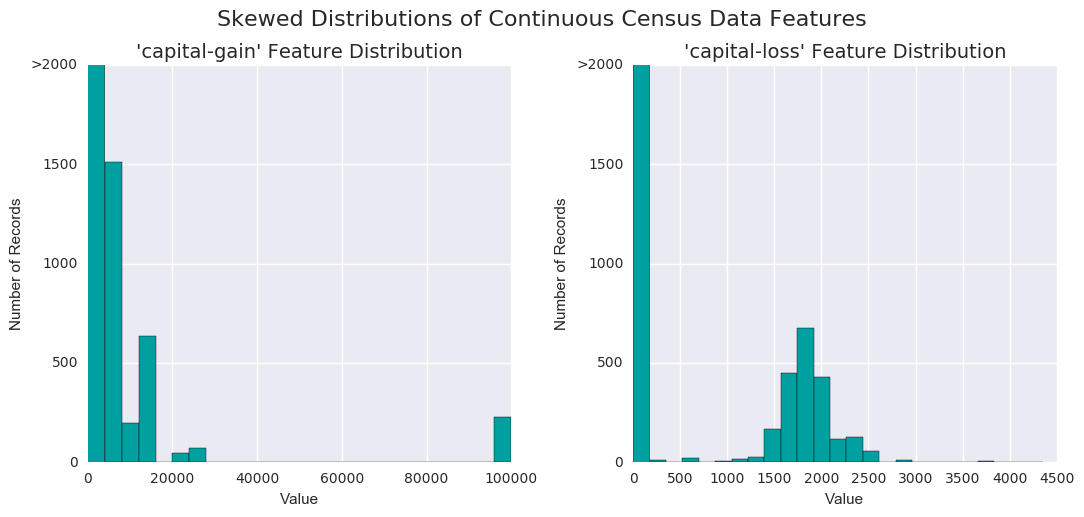

In [10]:
# Split the data into features and target label
import seaborn as sn 

income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

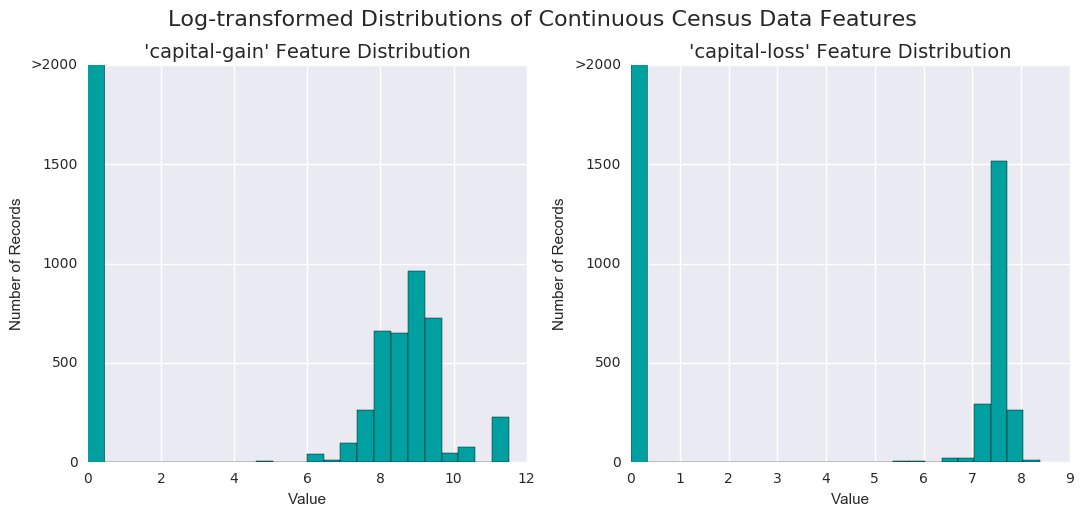

In [11]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for the numerical features. 

In [12]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, I will implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [24]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.replace([">50K","<=50K"], [1,0])

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [25]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for our data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


### Accuracy, Precision, Recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 


* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 


* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [45]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
#Calculate accuracy, precision and recall
pred = np.asarray([1]*n_records)
true_positives = income[(income == 1) & (pred == 1)].count()
true_negatives = income[(income == 0) & (pred == 0)].count()
false_positives = income[(income == 0) & (pred == 1)].count()
false_negatives = income[(income == 1) & (pred == 0)].count()

accuracy = float(true_positives+true_negatives)/n_records
precision = float(true_positives)/(true_positives+false_positives)
recall = float(true_positives)/(true_positives+false_negatives)


# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

beta = 0.5
fscore = (1+beta**2) * (precision*recall)/((precision*beta**2)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


##  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we can choose from:**
- **Gaussian Naive Bayes (GaussianNB)**: This model is a generative model (versus discriminative) which means that uses conditional probabililty (i.e. P(X|y)) versus joint probability (i.e. P(X,y)) as is the case for discriminative models. Generative models, model the distribution of individual classes. These models generally, converge quicker than discriminative ones making the a proper choice for large data-sets. Also, since the model works with the distribution of classes, in cases where we have large number of features and small number of observations, these models tend to perfom better than discriminative ones which are more prone to overfitting [1]. This model is also robust to noise/outliers, irrelevant, and missing values (just ignores them) which it a great choice for text labeling.  One disadvantage of Naive Bayes is that it does not account for interactions between features. For example, if we are analysing customers' comments about something, if we count "not", "good", and "bad" separately, this model will not be able to distinguish between "not good" and "not bad", unless we use bigrams. So correlating features is problematic in this case. This mdoel is not the best for continuous features it's a frequency-based algorithm and a lot of information may be lost in the binning process [1]. At last, since it makes a strong assumption that the classes follow a distribution which might not be the case. This issue might negatively affect the final results. 


- **Logistic Regression**: Logistic regression, is technically ordinary linear regression (OLS) when we substitite the response variable with logit function of y (i.e. $ln(\frac{p}{1-p})$). The major advantage of this model is that we get all the outputs that we generally get from an OLS model (i.e. P-values, R-square, CI for variables) as well as Odds ratio which emasures the probability of events. These outputs make logistics regression a great choce when we want to analyse and interpret the individual factors separately. These attributes make it a good choice for risk analysis [3]. Another advantage of Logistic regression is that it is applicable to online-learning, that is, one will not have to train the whole data once again in case of new oservations. One can avoid multi-collinearity between features and overfitting using regularization (i.e. L1 and L2) and since it's easy to use and can be found in most statistical tools it is widely used in industry [2]. This model is robust to noise and is rather fast. In practice, logistic regression is not that different from SVM with linear kernel [4]. One disadvantage of this model is that it relies on transforation for non-linear features. Another disadvantage is that it is only applicable for cases where the data is linearly seprable. 


- **Support Vector Machines (SVM)**: In cases where the data is not linearly separable, SVM works pretty well due to the kernel feature. SVM are pretty robust to high dimensionality and to this reason perform well in text classification [5]. One disadvantage of SVM is that it's pretty slow and takes a long time to train. Also, there are many hyperparameters that one needs to examine and play with in order to get an optimal model. For industrial scale data-sets where the number of observations are too many, this model may not work efficiently. Although the kernel feature is pretty use ful, it also increases the chance for over-fitiing [6]. 


- **Decision Trees**: One major advantage of this model is that they're easy to interpret. One can visualize the whole step-by-step partioning process with a [`dendogram`](https://shiring.github.io/machine_learning/2017/03/16/rf_plot_ggraph). This makes them a great candidate model for communicating our findings with the general audience. Another advantage is that this models are robust to outliers and the data does not have to be linearly separable. Also, being simple, there aren't as many parameters to change with this model, compared to more complicated models like SVM. This makes it easy to work it. These models perform best for cases where the number of features is small and the number of data points is large. One major disadvantage of this model is that it's easily prone to over-fitting. Although these pronblem have been resolved with bagging (Random Forest) and boosting (Adaboost) algorithms on decision trees. Another problem is that theya re not good choices for online learning as we will need to retrain the model every time with new observations. 


- **Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)**: In these algorithms we combine multiple models (weak learners) in some manner to find a mosaic model (strong learner) which tends to out-perform all other weak learners. The major advantage of this algorithms is that they enable us to avoid overfitting, that is, if our weak learners are not over-fit our model will never be over-fit either, while the strong learner always performs better than the weak learners. Using this methods we comprimise between bias and variance in an optimal way. If our models have high bias, boosting will be able to help whereas in case of high variance models, bagging will be the answer. Since we are using multiple models, this algorithms perform better where we have many data-points. One disadvantahe of these models is that they delivers poor probability estimates [7], that is, they perform well in case of classification, but if we are willing to reason the relationships between features, it may not be the best method. Due to higher accuracy and better performance, these methods are widely used in industry (e.g. collaborative filtering) [8].


- **K-Nearest Neighbors (KNeighbors)**: One major advantage of this method is that classes don't have to be linearly separable as it only relies on the neighbors.It's a simple method and accordingly easy to tune. It is also useful for online learning as classes can update easily with new observations. Disadvantages are high computatioonal cost as we need to calculate the distance from every observation from k other Points. Also, it is also not clear what would be the best number for K. Additionally, one has to rely on domain knowledge as to decide which distance type to use. The advantage of this model is that it is robust to noisy training data and it performs well on large training data sets. KNN algorithm is used in industry for searching similar items to a desired item [9].  


- **Stochastic Gradient Descent Classifier (SGDC)**: This method is used for cases where the number of observations is even higher than 100k and training a model may take a lot of time [10]. SGD is computationally fast and has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. One of the disadvantages is that it's sensitive to feature scaling. Anothe disadvantage is that it requires one to tune a number of hyper parameters which may require domain knowledge. 


**From the list above, I will choose three models to compare**:  Given the information I provided above, it looks like KNN and SGDC are not proper choices as our data set is not that large (i.e.e less than 100k rows). In our case, we have 103 features which is rather high-dimensional and given that regression trees are prone to overfitting, it might be a better idea to improve it's performance with some sort of ensemble method. Adaboost is one of the most common ones and seems to be a good choice. SVM, also seems to be fine, as we are dealing with a too many columns and not too many observations. Lastly, between Naive Bayse and Logistic Regression, I choose Logistic Regression, because given the types of features that are mostly demographic, we are likely to have some multi-collinearity in our data-set and Naive Bayse ignored the interactions entirely. Also, Naive bayse is merely frequency based and looses a lost of information when it comes to continuous variables. 

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - set the `beta` parameter

In [34]:
# Import two metrics from sklearn : fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score,accuracy_score
import numpy as np

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    start = time() # Get start time
    learner.fit(X_train.head(sample_size), y_train.head(sample_size))
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end- start
        
    #  Get the predictions on the test set(X_test),
    #  then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    beta = 0.5
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we will implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model we use, if provided.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** The following implementation may take some time to run!

C:\Users\sur216\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


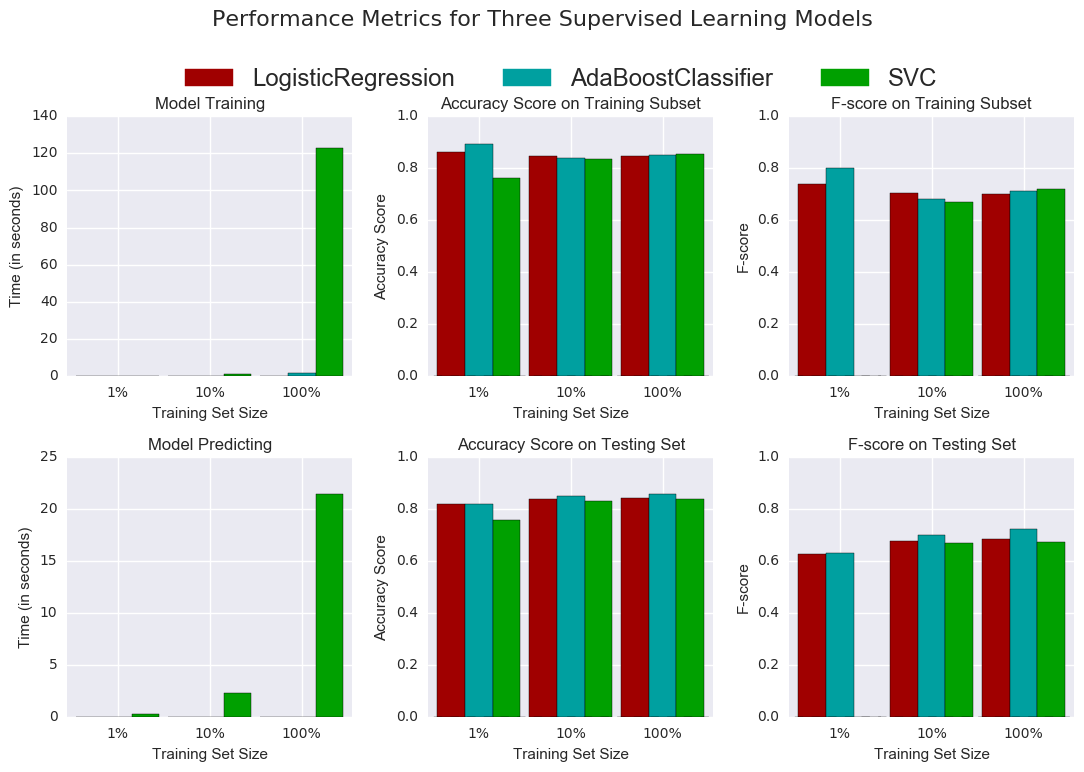

In [35]:
# Import the three supervised learning models from sklearn

from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = svm.SVC(random_state=0)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = LogisticRegression(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data

def get_sample_size(percentage):
    return int((float(percentage)/100)*X_train.shape[0])

samples_1 = get_sample_size(1.0)
samples_10 = get_sample_size(10.0)
samples_100 = get_sample_size(100.0)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the charity data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning some parameters to improve upon the untuned model's F-score. 

### Choosing the Best Model

Based on the evaluation you performed earlier, I would argue that the Adaboost algorithm shows a better performance compared to the other two. Generally, the three models are pretty close to one another in performance. However, as we can see in the bar-cgart on the bottom right, adaboost is slightly better than the other two in all previously defined subsets of the test set. Same pattern can be seen in the accuracy scores bar chart. By looking at the training set, we can see that in most cases SVM and Logisti Regression model are slightly better (except those on 1% subset). However, they perfomr worse when tried on the test set. This means that these two algorithms are may be overfit. 

Among the three algorithms, SVM is remarkably less efficient in terms of prediction/training time, as I had argued in the "Supervised Learning Models" section. SVM took 122 seconds once trained on the entire training set and 21 seconds for prediction. Adaboost was substantially more efficient (1.6 seconds for training and 0.06 seconds for prediction). Of these three algorithms, logistic regression was the fastest ( 0.22 for training and 0.0019 seconds for prediction). 

Given the F-scores and the training/prediction time, it lloks like Adaboost is our best choice. As explained earlier this model is suitable for our data. Our data-set is rather high-dimensional (103 features) and we have a fair number of observations (i.e. 42k. The dataset is not as noisy and there aren't too many outliers. In such cases decision trees are good options, however they are prone to overfitting. Adaboost, is an ensemble algorithm based on decision trees which enable us to avoid overfitting and weight different decision trees in their perfomance and use a combination of them. As it uses one-level decision trees as "weak learners" it is less likely to be over fit since a decision tree with max_depth=1 is generally not overfit due to being so simple.  

###  Describing Adaboost in Layman's Terms

Adaboost is one of the most famous boosting algorithms. Boostin algorithms enable us to combine a number of models and use the advantages of each, in order to reach to the best classifier. In simple words, this is pretty much like how we make important decisions in real life, that is, we consult our friends and families and try to combine their opinions to make the final decision. Boosting algorithms work in the same manner. These algorithms take a step-by-step process. First, they try the first model and then see how it works. Next, they will put weight on those points that were classified wrong. It can be resembled to a situation where consulting with the first person resolved some issues but left other issues unsolved. In this case, the person will go to another guy who can address those unresolved issues. In a same manner, By putting weight on wrongly classified points, the next model, will be chosen in a way that it solves those issues. These steps will be repeated until all your points are in the right classes. Every classifier, which is equivalent to every person that we consult with, is titled as "weak classifier". This figure [11] shows the process pretty well:


![title](bestrong.jpg)


It is important to note that these models are prone to overfitting only if our weak classifiers are overfit. In order to avoid this situation, we need to make sure that our weak classifiers are simple enough. In our consulting person example, it is equivalent to a situation where you don't want every single person you ask help from to talk too much. If they talk too much it makes you confused and you will not end up making the right decision! In adaboost algorithm, our weak classifiers are 1-level decision trees (i.e. max-depth = 1) by default. that is every weak classifier only asks one question to help us. We will then put these questions together and we will make the final decision!




###  Model Tuning
In this section we will fine tune the chosen model. We use grid search (`GridSearchCV`) on the entire training set for this. In the code cell below, we will implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [51]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
start = time()

from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
import pickle #to save the final model

# Initialize the classifier

clf = clf_B

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters = {'n_estimators': [10, 20, 40, 100,150,200],
               'algorithm': ['SAMME', 'SAMME.R'],
               'learning_rate': [.5, 1, 1.5, 2]}

#  Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# save the best classifier
with open("best_clf.pkl", "w") as f:
        pickle.dump(best_clf, f, 2)


# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


end = time()
# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nRun Time\n------"
print "Total run time: {:.4f}".format(end - start)
print "\nBest Parameters\n------"
print best_clf.get_params()

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8645
Final F-score on the testing data: 0.7375

Run Time
------
Total run time: 311.5630

Best Parameters
------
{'n_estimators': 150, 'base_estimator': None, 'random_state': 0, 'learning_rate': 1.5, 'algorithm': 'SAMME.R'}


### Final Model Evaluation

As we can see in the table of results below, both F-score and Accuracy score are the best in our optimized model, which means that our tuning has been successful. The unoptomized model is slightly worse, which means that the default hyperparameters of the adaboost algorithm weren't as bad after all, however, our tuning process using grid search enabled us to examine a variety of hyper parameters and arrive at the best ones. We can also see that our final model is significantly better than our benchmark predictore (i.e. naive predictore) that we discussed earlier. 

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |      0.8576       |   0.8645        |
| F-score        |      0.2917         |      0.7246       |   0.7375        |


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation

It is important to understand the importance of features intuitively before proceeding to our measurement tools. Given that we're trying to establish the maximum amount of income, I would use the following 5 features:

* capitals-gain: This variable is directly related to one's income as it has to do with one's investments and properties. 
* Education-num: Higher education affects ones income
* marital-status: married people are more likely to be aged and professional and therefore may have higher income. 
* age: Generally, as people grow older, they are more likely to gain more income up to a certain age. 
* hours-per-week: The more hours per-week one works the higher income he/she might have. 

###  Extracting Feature Importance
One of the attributes of Adaboost algorith is `feature_importances_`. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we will implement the following:
 - Train the adaboost model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

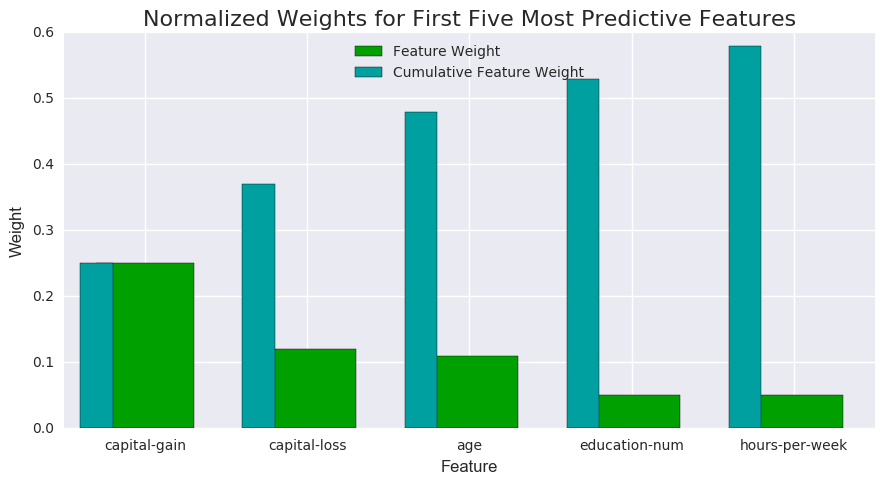

In [41]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf.fit(X_train,y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Only one of the variables that I had guessed was not among those resulted from feature extraction. This might make sense as in many large cities professional who actually have high incomes may not be married, necessarily. What I had missed in my intuitive guess was the capital loss which titally makes sense because it is directly related to income as is the case for capital gain. Another issue is in the ordering of the features, as I had guessed that education is the second factor but it turns out that age is even more important factor than education. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [55]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8645
F-score on testing data: 0.7375

Final Model trained on reduced data
------
Accuracy on testing data: 0.8379
F-score on testing data: 0.6898


###  Effects of Feature Selection

Once we train the model with only the five most important features we will find out that F-score dromps by only 0.05 and accuracy drops by 0.03. This means that our adaboost model relied mostly on the five variables that we talked about in the last section. Recall that our run time for training teh entire training set with 103 features was 311 seconds. If our dataset was larger, the run time would have exceeded specially if we have many hyperparameters to test and when teh algorithm is slow by nature (e.g. SVM). In such cases we will need to make sure that we reduce the number of features to some reasonable number. In this case using 5 features would have suffice. 

## References:

[1] John, George H., and Pat Langley. "Estimating continuous distributions in Bayesian classifiers." Proceedings of the Eleventh conference on Uncertainty in artificial intelligence. Morgan Kaufmann Publishers Inc., 1995.

[2] https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/

[3] Bayaga, Anass. "MULTINOMIAL LOGISTIC REGRESSION: USAGE AND APPLICATION IN RISK ANALYSIS." Journal of applied quantitative methods 5.2 (2010).

[4] https://d396qusza40orc.cloudfront.net/ml/docs/slides/Lecture12.pdf

[5] Pang, Bo, Lillian Lee, and Shivakumar Vaithyanathan. "Thumbs up?: sentiment classification using machine learning techniques." Proceedings of the ACL-02 conference on Empirical methods in natural language processing-Volume 10. Association for Computational Linguistics, 2002.


[6] Cawley, Gavin C., and Nicola LC Talbot. "On over-fitting in model selection and subsequent selection bias in performance evaluation." Journal of Machine Learning Research 11.Jul (2010): 2079-2107.


[7] https://stats.stackexchange.com/questions/109831/why-not-always-use-ensemble-learning


[8] http://blog.echen.me/2011/10/24/winning-the-netflix-prize-a-summary/


[9] https://www.quora.com/What-are-industry-applications-of-the-K-nearest-neighbor-algorithm


[10] http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

[11] https://cdstrainingprogram.github.io/slides/Lecture%209%20-%20Meta-Learning.pdf